# Data Analysis
## Load the data

In [76]:
import csv

def read_csv(file_name):
    lines = []
    with open(file_name) as driving_log:
        reader = csv.reader(driving_log)
        next(reader, None)
        for line in reader:
            lines.append(line)

    return lines

print("Loading csv file ...")
csv_file_name = 'data/driving_log.csv'
lines = read_csv(csv_file_name)
csv_file_name = 'data1/driving_log.csv'
lines.extend(read_csv(csv_file_name))
print("Finished loading csv file")
print ("Total # of recordings: {0}".format(len(lines)))

Loading csv file ...
Finished loading csv file
Total # of recordings: 19436


## Using multiply cameras

In [77]:
import cv2
import numpy as np
import re


def load_image(image_path):
    pattern = re.compile(r'/|\\')
    file_name = pattern.split(image_path)[-1]
    current_path = 'data/IMG/' + file_name
    #print(current_path)
    image_bgr = cv2.imread(current_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    return image_rgb

def preprocess_data(lines):
    images = []
    steerings = []

    for line in lines:
        # centre
        images.append(load_image(line[0]))
        # left
        images.append(load_image(line[1]))
        # right
        images.append(load_image(line[2]))

        centre_steering = float(line[3])
        correction = 0.2
        # centre
        steerings.append(centre_steering)
        # left
        steerings.append(centre_steering+correction)
        # right
        steerings.append(centre_steering-correction)

    return images, steerings

images, steerings = preprocess_data(lines)
print ("Total # of images: {0}".format(len(images)))
print ("Total # of steerings: {0}".format(len(steerings)))

Total # of images: 58308
Total # of steerings: 58308


## Visualize some original images

Images are also cropped so that the top and the bottom of the scene, which are rather distracting for the model, are left out to help the training process

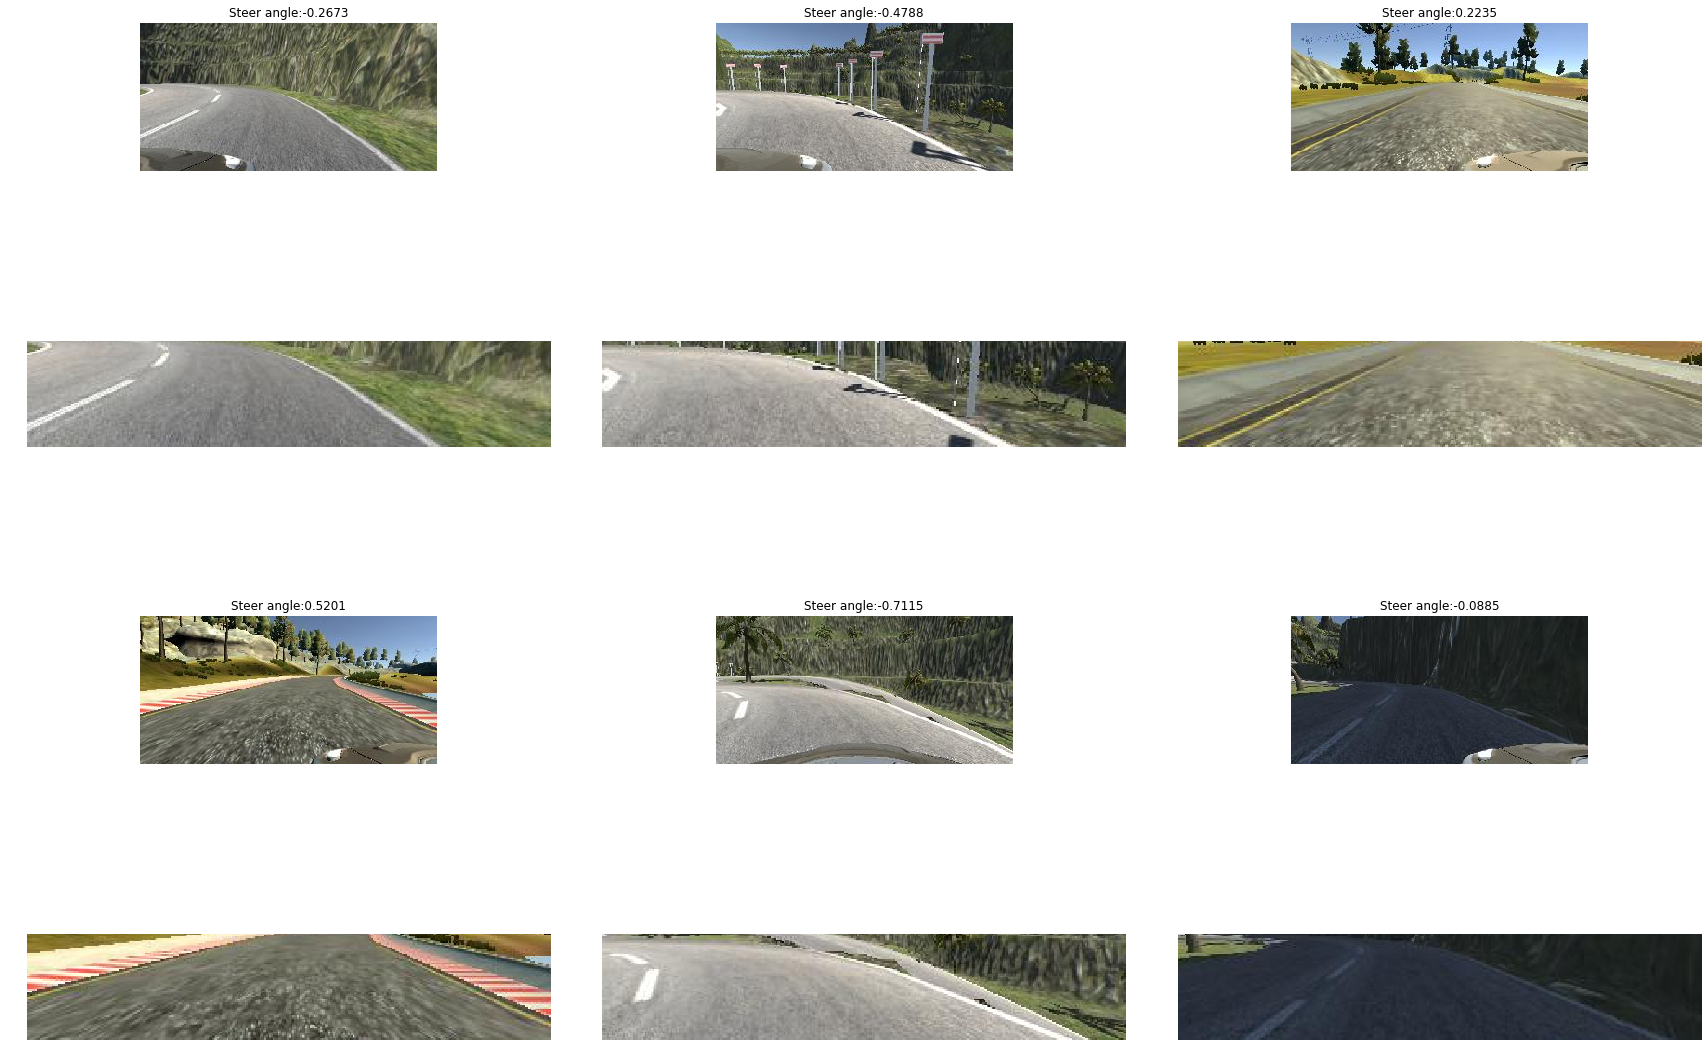

In [78]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def draw_samples(rows,cols, images, steerings):
    plt.figure(figsize = (30,30))
    grid = gridspec.GridSpec(rows*2,rows)
    # set the spacing between axes.
    grid.update(wspace=0.1, hspace=1)  

    for i in range(0, rows, 2):
        for j in range(cols):
            idx = i * cols + j
            img_plt = plt.subplot(grid[idx])
            plt.axis('on')
            img_plt.set_xticklabels([])
            img_plt.set_yticklabels([])
            img_plt.set_aspect('auto')
            index = np.random.randint(0,len(images))
            plt.imshow(images[index])
            plt.title('Steer angle:' + str(np.round(steerings[index],4)))
            plt.axis('off')
            img_plt = plt.subplot(grid[idx + cols])
            plt.axis('off')
            # Cropp the top 70 and bottom 25 pixels out of the original
            plt.imshow(images[index][70:135,:])
    plt.show()
    
draw_samples(3, 3, images, steerings)

## Data augmentation

### Random translation

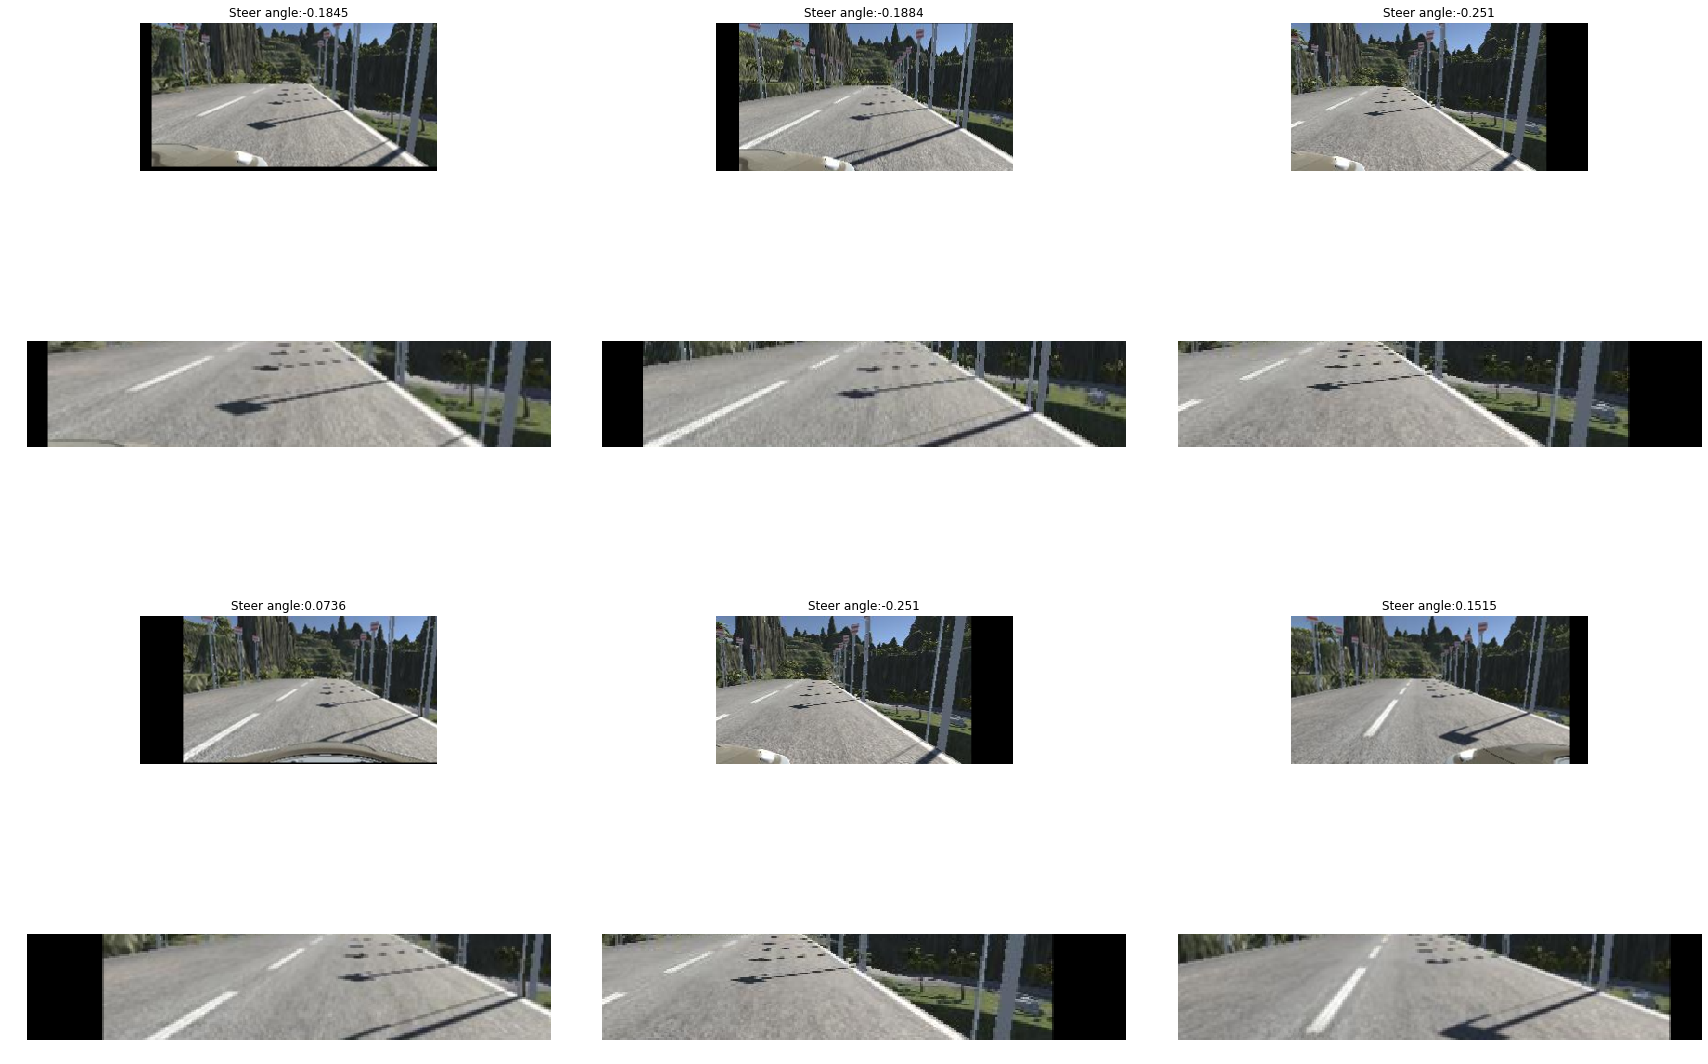

In [79]:
import copy

def random_translate(image, steering, range_x=100, range_y=10):
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steering += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering

random_start = int(np.random.uniform(0, len(images)))
random_end = random_start + 128
images_test = images[random_start: random_end]
steerings_test = steerings[random_start : random_end]
images_translated = []
steerings_translated = []
for image, steering in zip(images_test, steerings_test):
    image_translated, steering_translated = random_translate(image, steering)
    images_translated.append(image_translated)
    steerings_translated.append(steering_translated)
draw_samples(3, 3, images_translated, steerings_translated)

### Random exposure

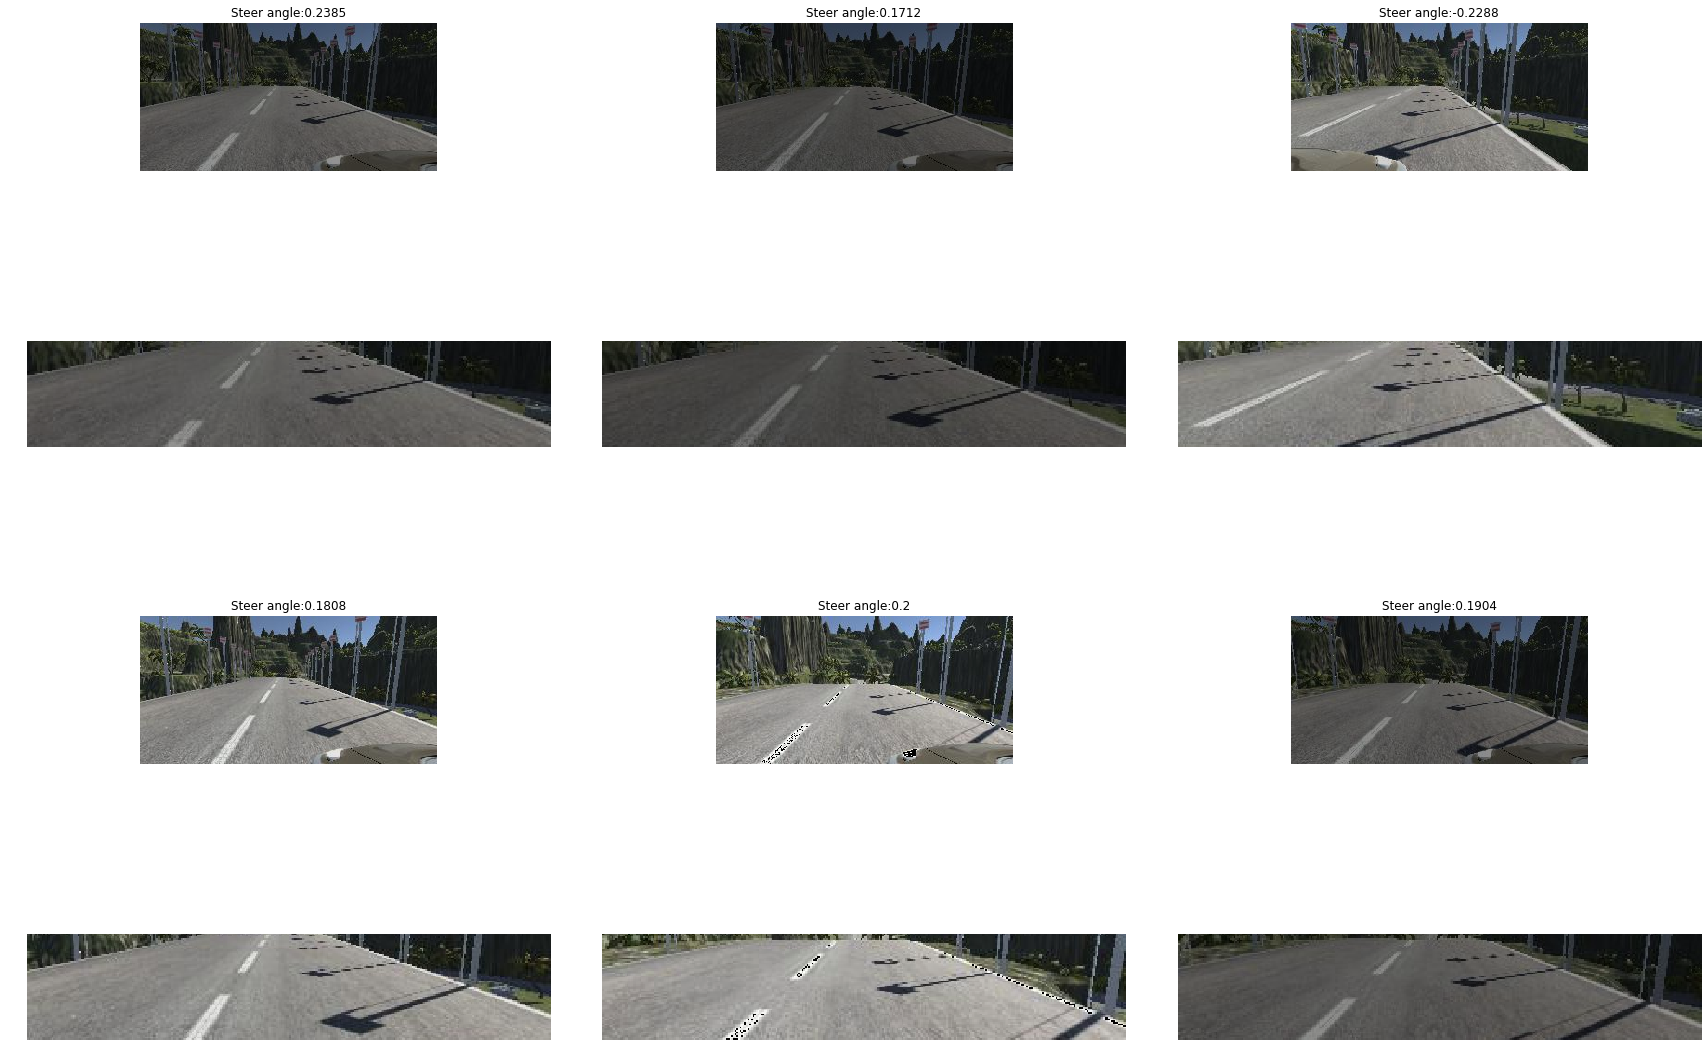

In [80]:
def random_exposure(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

images_exposure = []
steerings_exposure = []
for image, steering in zip(images_test, steerings_test):
    image_exposure = random_exposure(image)
    images_exposure.append(image_exposure)
    steerings_exposure.append(steering)
draw_samples(3, 3, images_exposure, steerings_exposure)

### Random shadow

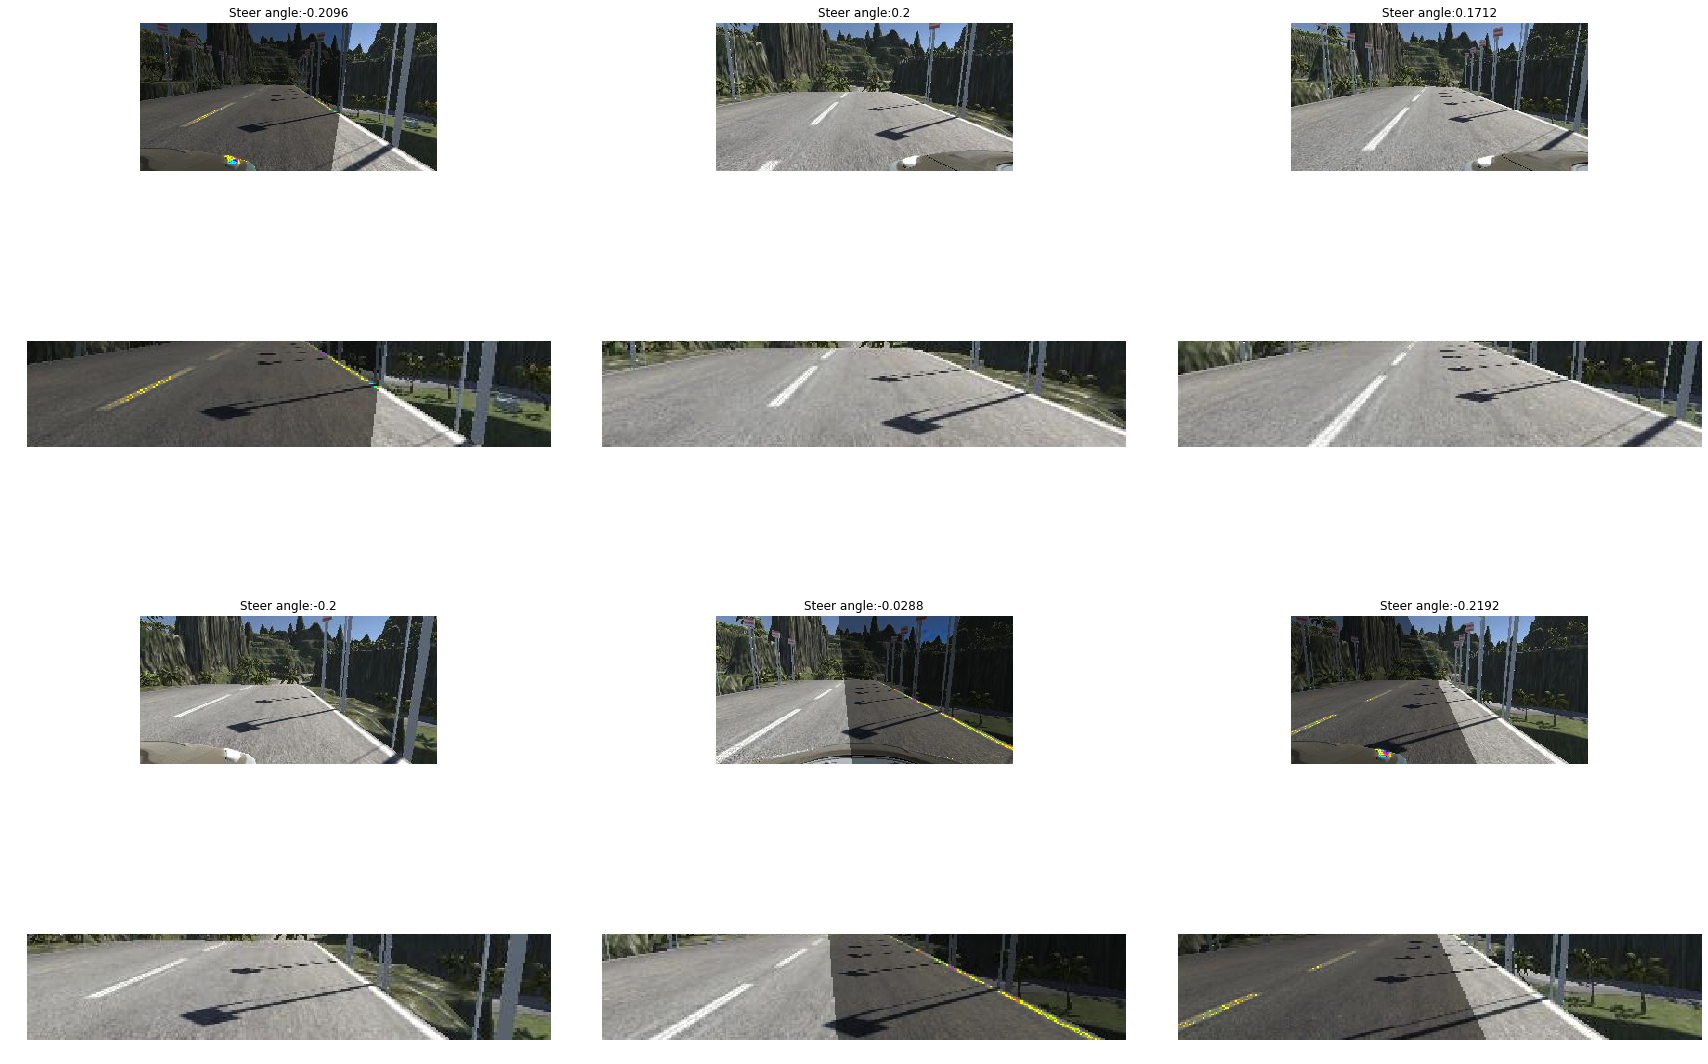

In [82]:
def random_shadow(image):
    top_y = 320*np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    if np.random.randint(2)==1:
        random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    return image

images_shadow = []
steerings_shadow = []
for image, steering in zip(images_test, steerings_test):
    image_shadow = random_shadow(image)
    images_shadow.append(image_shadow)
    steerings_shadow.append(steering)
draw_samples(3, 3, images_shadow, steerings_shadow)